# Shiller Exercise
 
- Will add better code comenting and documentation when time permits in future.

In [128]:
import pandas as pd
import math
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import statsmodels.formula.api as smf


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999

In [129]:
data = pd.read_excel('/Users/edwardhuang/Documents/chapt26.xlsx', sheet_name = 'Data_edit')

In [130]:
# Turn the index, which is the year, into its own column and re-index
data.reset_index(inplace = True)

data['year'] = data['index']
data.drop(columns = 'index', inplace = True)

In [131]:
data.shape

(146, 20)

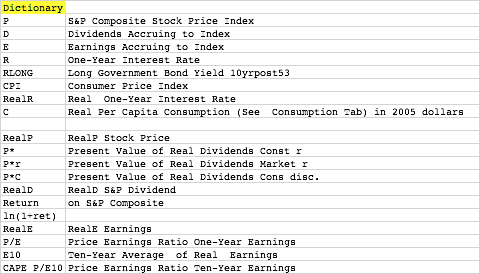

Notes:
- 146 years, 1871 - 2016
- 19 variables

# Replicate Bottom Panel of Figure 6

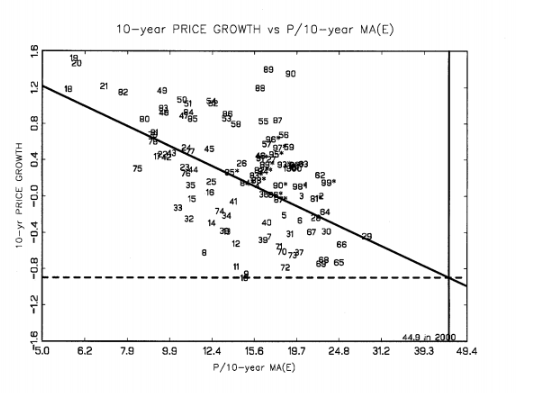

In [132]:
# Fig 6: 10 year Price Growth vs. P/10y MA(E)
# Paper here: http://www.nber.org/papers/w8221

In [133]:
# Subset Dataset to only years up to 1999 to create Shiller's old dataset at the time of research
dfa = data[data['year'] <= 1999]

In [134]:
# Create last CPI variable to reset the Real values based on 1999 last year.
last_cpi = dfa[dfa['year'] == 1999].iloc[0]['CPI']


In [135]:
# Recreate the Real Columns for Price and Earnings
dfa['RealP'] = dfa['P'] * last_cpi / dfa['CPI']
dfa['RealE'] = dfa['E'] * last_cpi / dfa['CPI']

In [136]:
# Get the Moving Average of Earnings, 10 years
dfa['E10'] = pd.rolling_mean(dfa, 10)['RealE']

# Get the CAPE, Real Price / E10 over last 10 years. Shift method lags the E10 by 10 years so I don't include the current year's earnings.
dfa['CAPE P/E10'] = dfa['RealP'] / dfa['E10'].shift(1)

In [137]:
# Get the change in natural log Price over next 10 years, on a rolling basis
dfa['P_Growth_10'] \
    = dfa['RealP'].shift(-10).apply(lambda x: math.log(x, math.e)) \
    - dfa['RealP'].apply(lambda x: math.log(x, math.e))

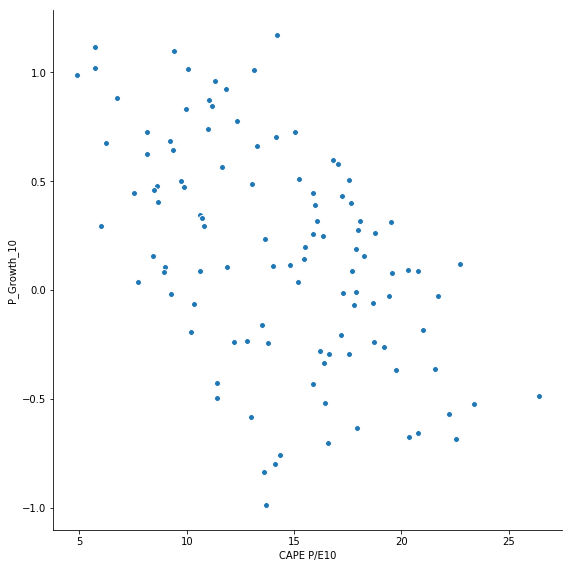

In [138]:
# Plot the scatterplot to check data before running regression
sns.pairplot(dfa, x_vars='CAPE P/E10', y_vars='P_Growth_10', size = 8, )

In [139]:
# Transform CAPE into natural log scale
dfa['log_CAPE'] = np.log(dfa['CAPE P/E10'])

In [140]:
# There are null values because of the Moving Averages (first 10 lines don't have a MA) and last 10 lines don't have 10y Price Growth
# Drop those null values for the regression
dfa = dfa[np.isfinite(dfa['log_CAPE'])]
dfa = dfa[np.isfinite(dfa['P_Growth_10'])]

In [141]:
X = dfa['log_CAPE']
y = dfa['P_Growth_10']

In [142]:
# Must reshape the matrix into 1 row each for regression
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [143]:
# Instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

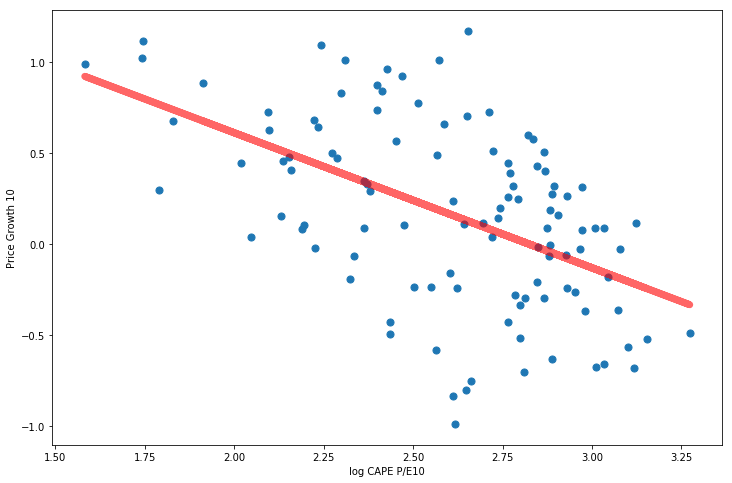

In [144]:
#Make predictions by passing X into model
preds = linreg.predict(X)

#Set plot size to (12,8)
plt.figure(figsize=(12, 8))
#Make scatter of X and y
plt.scatter(X,y, s = 50)
#Make line plot of X and preds
plt.plot(X, preds, "r", linewidth= 7, alpha = .6)
plt.xlabel("log CAPE P/E10")
plt.ylabel("Price Growth 10");

In [145]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

[2.09782278]
[[-0.7428528]]


In [146]:
print("MSE: %.2f"
      % mean_squared_error(y, preds))
print('R2: %.2f' % r2_score(y, preds))


MSE: 0.19
R2: 0.27


Formal Regression Equation: 
y = 2.1 - 0.74x

### R2 of .27

# Recreate Model with data up to 2013

In [147]:
# Create function with all the commands from above with variable inputs to make repetition easier

def data_trans(dfa, last_cpi_year):

    last_cpi = dfa[dfa['year'] == last_cpi_year].iloc[0]['CPI']
    
    # Recreate the Real Columns for Price and Earnings
    dfa['RealP'] = dfa['P'] * last_cpi / dfa['CPI']
    dfa['RealE'] = dfa['E'] * last_cpi / dfa['CPI']
    # Get the Moving Average of Earnings, 10 years
    dfa['E10'] = pd.rolling_mean(dfa, 10)['RealE']

    # Get the CAPE, Real Price / E10 over last 10 years. Shift method lags the E10 by 10 years so I don't include the current year's earnings.
    dfa['CAPE P/E10'] = dfa['RealP'] / dfa['E10'].shift(1)
    # Get the change in natural log Price over next 10 years, on a rolling basis
    dfa['P_Growth_10'] \
        = dfa['RealP'].shift(-10).apply(lambda x: math.log(x, math.e)) \
        - dfa['RealP'].apply(lambda x: math.log(x, math.e))

    # Transform CAPE into natural log scale
    dfa['log_CAPE'] = np.log(dfa['CAPE P/E10'])
    # There are null values because of the Moving Averages (first 10 lines don't have a MA) and last 10 lines don't have 10y Price Growth
    # Drop those null values for the regression
    dfa = dfa[np.isfinite(dfa['log_CAPE'])]
    dfa = dfa[np.isfinite(dfa['P_Growth_10'])]
    
    return dfa

In [148]:
def lin_reg(dfa, X_col, reg_model):
    #X = dfa['log_CAPE']
    X = dfa[X_col]
    y = dfa['P_Growth_10']
    # Reshape only if there is only one column

    if len(X_col) == 1:
        X = np.array(X)
        
    y = y.reshape(-1,1)
    # Instantiate and fit
    linreg = reg_model
    linreg.fit(X, y)
    #Make predictions by passing X into model
    preds = linreg.predict(X)
    
    # print the coefficients
    print('y = ',linreg.coef_,X_col,' + ',linreg.intercept_)
    print("MSE: %.2f"
      % mean_squared_error(y, preds))
    print('R2: %.2f' % r2_score(y, preds))
    #print("Cross Validated MSE: ", -1 * cross_val_score(LinearRegression(), X, y, cv = 3, scoring = "neg_mean_squared_error").mean())
    #print("Cross Validated R2", cross_val_score(LinearRegression(), X, y, cv = 3, scoring = "r2").mean())
    
    return linreg

In [149]:
def preds(dfa, X_col, reg_model):
    #X = dfa['log_CAPE']
    X = dfa[X_col]
    y = dfa['P_Growth_10']
    # Reshape only if there is only one column

    if len(X_col) == 1:
        X = np.array(X)
        
    y = y.reshape(-1,1)
    # Instantiate and fit
    linreg = reg_model
    linreg.fit(X, y)
    #Make predictions by passing X into model
    preds = linreg.predict(X)
    
    return preds

In [150]:
def r2(dfa, X_col, reg_model):
    #X = dfa['log_CAPE']
    X = dfa[X_col]
    y = dfa['P_Growth_10']
    # Reshape only if there is only one column

    if len(X_col) == 1:
        X = np.array(X)
        
    y = y.reshape(-1,1)
    # Instantiate and fit
    linreg = reg_model
    linreg.fit(X, y)
    #Make predictions by passing X into model
    preds = linreg.predict(X)
    
    return r2_score(y, preds)

In [151]:
# Change dataset up to 2013
dfa = data[data['year'] <= 2013]

In [152]:
model1 = lin_reg(data_trans(dfa, 2013), ['log_CAPE'], LinearRegression())

y =  [[-0.57675713]] ['log_CAPE']  +  [1.72319056]
MSE: 0.21
R2: 0.20


### R2 dropped to .20

Check p values to make sure variables are significant

In [153]:
import statsmodels.formula.api as smf

# create a fitted model
lm1 = smf.ols(formula='P_Growth_10 ~ log_CAPE', data=dfa).fit()
lm1.pvalues

Intercept    1.379098e-08
log_CAPE     2.129062e-07
dtype: float64

# What are your key conclusions from these results?

MSE increased and R2 decreased for the model in the years between 1999 and 2013.

The drop in R2 and the increase in MSE suggests a few possibilities:
1. Price Growth variance increased from 1999-2013
2. CAPE ratio has less predictive power 

First, I'd like to check the variance of the Y variable (Price Growth) and see if we can do anything to reduce the variance/noise. There were two large recessions from 1999-2013 (dotcom bubble and housing crash) which likely added Y noise. 

Second, I'd like to adjust the model to train on trailing N years rather than the entire history to try to work around a possible regime shift. I'd also like to add variables for more information such as real interest rates and QE dummy.

Regime shift explanations include:
- Structural Changes to Index
- Changes to Accounting Practices
- Payout Ratio Changes
- QE

# Model Improvement Ideas:
1. Remove extreme outlier years from training data
2. Create Trailing model
3. Add variables (Real Interest Rates and QE dummy)
4. Add VIX to allow model to take in implied vol

### 1.

Get view of current Earnings fluctuation

In [154]:
dfa = data[data['year'] <= 2013]

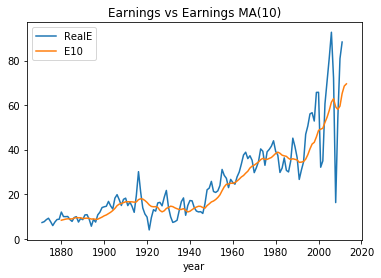

In [155]:
dfa.plot(x='year',y=['RealE','E10'])
plt.title("Earnings vs Earnings MA(10)") ;

Check out R2 change as you remove more and more of the top outlier years in terms of Earnings

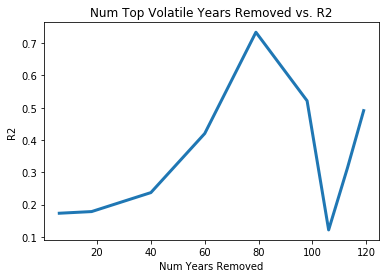

In [156]:
cv = []
num_years = []
pct_E_chg = [.03,.05,.07,.10,.15,.20,.30,.40,.50]
for value in pct_E_chg:
    dfa = data[data['year'] <= 2013]
    years = list(dfa[abs((dfa['RealE'] - dfa['E10'])/dfa['E10']) > value]['year'])
    dfa = dfa[~dfa['year'].isin(years)]
    num_years.append(len(years))
    cv.append(r2_score(data_trans(dfa, 2013)['P_Growth_10'],preds(data_trans(dfa, 2013), ['log_CAPE'], LinearRegression())))
        


plt.plot(num_years, cv, linewidth = 3)
plt.xlabel("Num Years Removed")
plt.ylabel("R2")
plt.title("Num Top Volatile Years Removed vs. R2") ;

Removing years that had Real Earnings higher/lower than E10 by 15% increased R2 by a bit, but it removes a significant number of years.

In [157]:
dfa = data[data['year'] <= 2013]
# Identify Years
years = list(dfa[abs((dfa['RealE'] - dfa['E10'])/dfa['E10']) > 0.15]['year'])

In [158]:
# Recreate dfa to exclude those years
dfb = dfa[~dfa['year'].isin(years)]

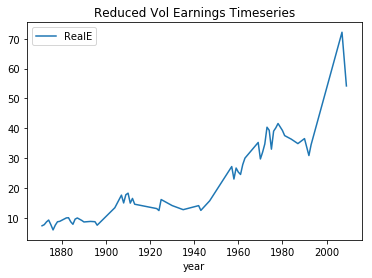

In [159]:
# Check out the Earnings fluctuation again with remaining years
dfb.plot(x='year',y='RealE')
plt.title("Reduced Vol Earnings Timeseries") ;

In [160]:
model2 = lin_reg(data_trans(dfb, 2013), ['log_CAPE'], LinearRegression())

y =  [[-1.48230796]] ['log_CAPE']  +  [4.51742085]
MSE: 0.11
R2: 0.73


### R2 of .73

### 2.

Create Trailing model to adjust for Regime shifts

In [161]:
def lin_reg2(dfa, X_col, reg_model):
    #X = dfa['log_CAPE']
    X = dfa[X_col]
    y = dfa['P_Growth_10']
    # Reshape only if there is only one column

    if len(X_col) == 1:
        X = np.array(X)
        
    y = y.reshape(-1,1)
    # Instantiate and fit
    linreg = reg_model
    linreg.fit(X, y)
   
    return linreg

In [162]:
trailing = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

In [163]:
r2 = []

In [164]:
for trail in trailing:
    years_trail = []
    preds_trail = []
    actuals_trail = []
    
    for year in range(1881,2004-trail):
        dfa = data_trans(data, year)
        dfb = dfa[(dfa['year']< year+trail) & (dfa['year']>= year)]
        x = lin_reg2(dfb, ['log_CAPE'], LinearRegression())

        #prediction
        preds_trail.append(x.predict(dfa[dfa['year'] == year+trail]['log_CAPE'].reshape(-1,1))[0][0])
        years_trail.append(year+trail)
        actuals_trail.append(dfa[dfa['year'] == year+trail]['P_Growth_10'].values[0])

    r2.append(r2_score(actuals_trail,preds_trail))

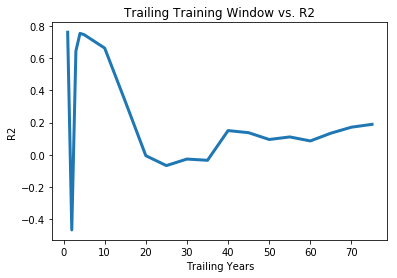

In [165]:
plt.plot(trailing, r2, linewidth = 3)
plt.xlabel("Trailing Years")
plt.ylabel("R2")
plt.title("Trailing Training Window vs. R2") ;

Creating a more recent training period to test on current data increases R2 significantly, which supports the idea of constantly changing financial environments and the outdatedness of old data.

R2 Trends up steadily until around a 5 year trailing window, which you then see R2 fluctuate wildly. I would use a ~8 year trailing window to be safe

In [166]:
trail = 8
years_trail = []
preds_trail = []
actuals_trail = []
for year in range(1881,2004-trail):
    dfa = data_trans(data, year)
    dfb = dfa[(dfa['year']< year+trail) & (dfa['year']>= year)]
    x = lin_reg2(dfb, ['log_CAPE'], LinearRegression())

    #prediction
    preds_trail.append(x.predict(dfa[dfa['year'] == year+trail]['log_CAPE'].reshape(-1,1))[0][0])
    years_trail.append(year+trail)
    actuals_trail.append(dfa[dfa['year'] == year+trail]['P_Growth_10'].values[0])


### R2 of .70

### 3.

We are beginning to add more variables into our Model. These variables have different means and STD so I want to scale them.

In [167]:
dfa = data_trans(data, 2013)
dfa['Real_RLONG'] = dfa['RLONG'] * last_cpi / dfa['CPI']
#Used 1998 because 2008 was first year of QE, so 1998 P_Growth_10 is affected.
dfa['QE'] = dfa['year'].apply(lambda x: 1 if x >= 1998 else 0)
dfa_trans = dfa[['P_Growth_10','log_CAPE','Real_RLONG','QE']]


In [168]:
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(dfa_trans)
scaled_df = pd.DataFrame(scaled_df, columns=['Real_RLONG','P_Growth_10','log_CAPE','QE'])

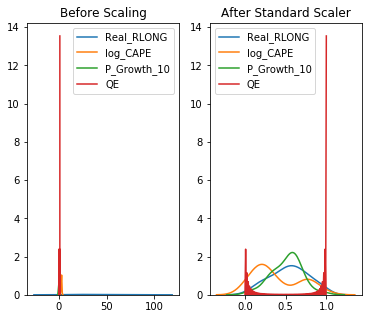

In [169]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(dfa_trans['Real_RLONG'], ax=ax1)
sns.kdeplot(dfa_trans['log_CAPE'], ax=ax1)
sns.kdeplot(dfa_trans['P_Growth_10'], ax=ax1)
sns.kdeplot(dfa_trans['QE'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['Real_RLONG'], ax=ax2)
sns.kdeplot(scaled_df['log_CAPE'], ax=ax2)
sns.kdeplot(scaled_df['P_Growth_10'], ax=ax2)
sns.kdeplot(scaled_df['QE'], ax=ax2)
plt.show()

In [170]:
#dfa = data[data['year'] <= 2013]
#dfb['Real_RLONG'] = dfb['RLONG'] * last_cpi / dfa['CPI']

model3 = lin_reg(scaled_df, ['log_CAPE','Real_RLONG','QE'], LinearRegression())

y =  [[-0.03318445 -0.31469929  0.31836651]] ['log_CAPE', 'Real_RLONG', 'QE']  +  [0.67603775]
MSE: 0.02
R2: 0.38


### R2 of .38

In [171]:
# Check pvalues to make sure variables are significant
lm1 = smf.ols(formula='P_Growth_10 ~ log_CAPE + Real_RLONG + QE', data=scaled_df).fit()
lm1.pvalues

Intercept     1.523331e-26
log_CAPE      5.343147e-01
Real_RLONG    1.385759e-06
QE            5.924813e-07
dtype: float64

Adding Real_RLONG did not affect R2 much

I wanted to add a dummy variable to show QE years but with the years removed previously, there are no QE years left anyway.

Try using Pipeline to Scale and Regress next time. Also Try to do model3 without the changes from model2

In [172]:
#clf = make_pipeline(StandardScaler(), LinearRegression())
#cross_val_score(clf, X, y, cv=5, scoring = "neg_mean_squared_error").mean()

### 4. Plan to add VIX to measure implied volatility in the model in the future!

# Investment Strategy Ideas:
1. Simple binary investing cash vs sp500 based on price growth predictor, reevaluate 1 year cycles. Use on Original CAPE Model
2. Use same strategy on New CAPE Model
2. Weighted investing - Compute different weightings (1%/99%, 2%/98%, so on). reevaluate 1 year cycles


### 1.

- When CAPE predicts Price Growth over next 10 years to be positive, allocate 100% to S&P 500. 
- When prediction is negative, allocate 100% to cash.

First, use model with only CAPE as predictor variable.

In [173]:
def category(y_pred):
    if y_pred > 0:
        return 1
    else:
        return 0

In [174]:
def strat(dfa):
    pct_growth = dfa['Return']

    if dfa['preds'] > 0:
        return 1 + pct_growth
    else:
        return 1

In [175]:
dfa = data[data['year'] <= 2013]
dfa = data_trans(dfa, 2013)


In [176]:
model = model1
dfa['preds'] = model.predict(dfa['log_CAPE'].reshape(-1,1))

In [177]:
dfa['Model1_Position'] = dfa['preds'].apply(category)

In [178]:
dfa['Model1_Return'] = dfa.apply(strat, axis = 1)

In [179]:
dfa['Cum_Model1_Return'] = dfa['Model1_Return'].cumprod()
dfa['sp500_running_return'] = dfa['Return'].apply(lambda x: x+1).cumprod()

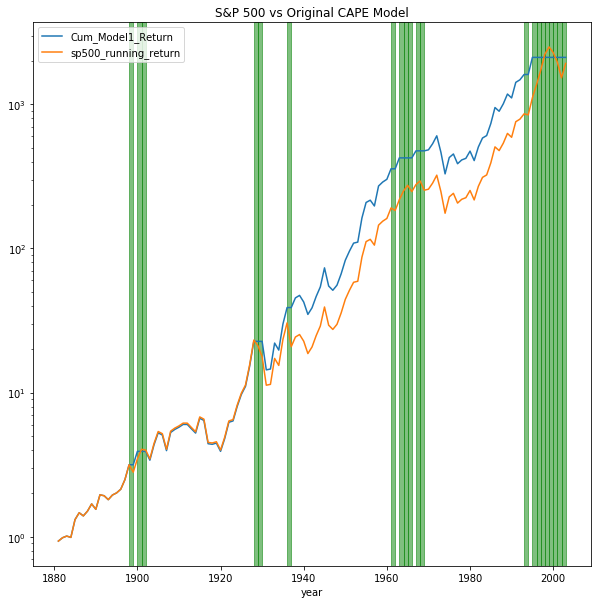

In [180]:
dfa.plot(x = 'year', y = ['Cum_Model1_Return', 'sp500_running_return'], logy = True, figsize = (10,10))
for year in dfa[dfa['Model1_Position'] == 0]['year']:
    plt.axvspan(year-1, year, color='green', alpha=0.5)
    plt.title("S&P 500 vs Original CAPE Model") ;
#https://stackoverflow.com/questions/8270981/in-a-matplotlib-plot-can-i-highlight-specific-x-value-ranges

### Max Drawdowns

In [181]:
print('S&P 500 Benchmark Max Drawdown: ',dfa['Return'].min())
print('Strat1 Max Drawdown: ',(dfa['Model1_Return']-1).min())

S&P 500 Benchmark Max Drawdown:  -0.36543056442931293
Strat1 Max Drawdown:  -0.365430564429313


### Number of Years invest vs not

In [182]:
foo = pd.DataFrame(dfa['Return'].apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())
foo1 = pd.DataFrame((dfa['Model1_Return']-1).apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())
foo.join(foo1, how = 'outer')

,Return,Model1_Return
-1,41.0,29
0,NaN,21
1,82.0,73


### Histogram for Volatility

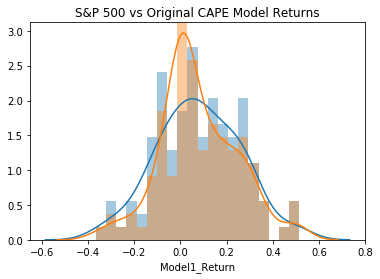

In [183]:
# compare all years vs strategy s&p invested years
sns.distplot(dfa['Return'], bins = 20)
sns.distplot(dfa['Model1_Return'] -1, bins = 20)
plt.title("S&P 500 vs Original CAPE Model Returns") ;

### Standard Deviation and Mean (Risk Adjusted Return)

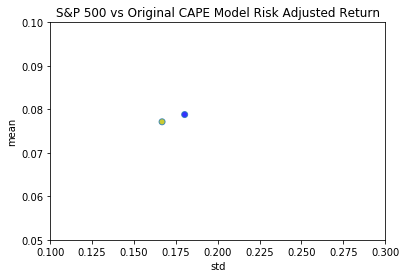

In [184]:
df = pd.DataFrame([[(dfa['Model1_Return']-1).mean(), (dfa['Model1_Return']-1).std(), "y"],
                 [dfa['Return'].mean(), dfa['Return'].std(), "b"]],
                 columns = ['mean','std', 'color'])

f, ax = plt.subplots()
ax.set(xlim=(.1, .3), ylim=(0.05, .1))
sns.regplot(x = 'std', y= 'mean', data = df, fit_reg=False, scatter_kws={'facecolors':df['color']})
plt.title("S&P 500 vs Original CAPE Model Risk Adjusted Return") ;
#https://python-graph-gallery.com/45-control-color-of-each-marker-seaborn/


## 2.

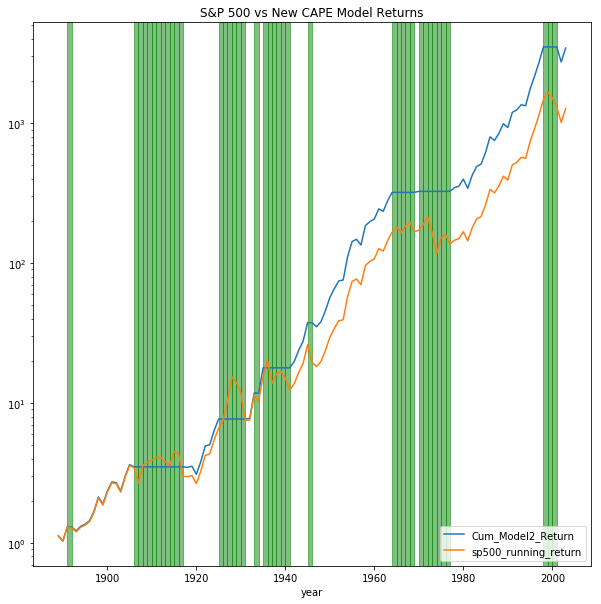

In [185]:
#dfb = data[data['year'] <= 2013]
dfb = data_trans(data, 2013)
dfb = dfb[dfb['year'].isin(years_trail)]

dfb['preds'] = preds_trail
dfb['Model2_Position'] = dfb['preds'].apply(category)

dfb['Model2_Return'] = dfb.apply(strat, axis = 1)

dfb['Cum_Model2_Return'] = dfb['Model2_Return'].cumprod()
dfb['sp500_running_return'] = dfb['Return'].apply(lambda x: x+1).cumprod()

dfb.plot(x = 'year', y = ['Cum_Model2_Return', 'sp500_running_return'], logy = True, figsize = (10,10))
for year in dfb[dfb['Model2_Position'] == 0]['year']:
    plt.axvspan(year-1, year, color='green', alpha=0.5)
    plt.title("S&P 500 vs New CAPE Model Returns") ;
#https://stackoverflow.com/questions/8270981/in-a-matplotlib-plot-can-i-highlight-specific-x-value-ranges

### Max Drawdowns

In [186]:
print('S&P 500 Benchmark Max Drawdown: ',dfa['Return'].min())
print('Strat1 Max Drawdown: ',(dfa['Model1_Return']-1).min())
print('Strat2 Max Drawdown: ',(dfb['Model2_Return']-1).min())

S&P 500 Benchmark Max Drawdown:  -0.36543056442931293
Strat1 Max Drawdown:  -0.365430564429313
Strat2 Max Drawdown:  -0.22047371020594797


### Num Years invest vs not

In [187]:
foo = pd.DataFrame(dfa['Return'].apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())
foo1 = pd.DataFrame((dfa['Model1_Return']-1).apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())
foo2 = pd.DataFrame((dfb['Model2_Return']-1).apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1).value_counts())
foo.join((foo1, foo2), how = 'outer')

,Return,Model1_Return,Model2_Return
-1,41.0,29,16
0,NaN,21,41
1,82.0,73,58


### Histogram for Volatility

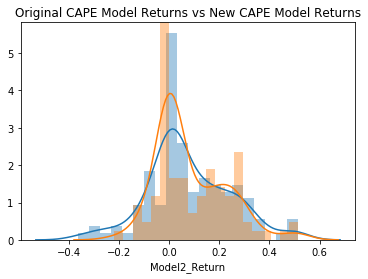

In [188]:
# compare all years vs strategy s&p invested years
sns.distplot(dfa['Model1_Return'] -1, bins = 20)
sns.distplot(dfb['Model2_Return'] -1, bins = 20)
plt.title("Original CAPE Model Returns vs New CAPE Model Returns") ;

asd


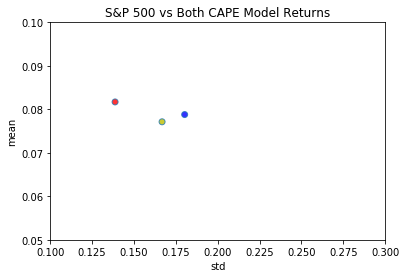

In [189]:
df = pd.DataFrame([[(dfa['Model1_Return']-1).mean(), (dfa['Model1_Return']-1).std(), "y"],
                   [(dfb['Model2_Return']-1).mean(), (dfb['Model2_Return']-1).std(), "r"],
                 [dfa['Return'].mean(), dfa['Return'].std(), "b"]],
                 columns = ['mean','std', 'color'])

f, ax = plt.subplots()
ax.set(xlim=(.1, .3), ylim=(0.05, .1))
sns.regplot(x = 'std', y= 'mean', data = df, fit_reg=False, scatter_kws={'facecolors':df['color']})
plt.title("S&P 500 vs Both CAPE Model Returns") ;
#https://python-graph-gallery.com/45-control-color-of-each-marker-seaborn/


### 3. Further analysis for nuanced weighting strategy to be pursued in future!

Set list of weighting pairs (1%/99%, 2%/98%, so on) and run the backtest for all of these weighting to see what level of cash weighting/investment weighting is optimal. Can show results in heatmap.